In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import os
import time

#### **Pesos**

In [2]:
# Caminho para o arquivo
arquivo = "Populacao.txt"

if os.path.exists(arquivo) and os.path.getsize(arquivo) > 0:
    geracao = np.loadtxt(arquivo, dtype=float)
else:
    # Define a semente para reprodutibilidade
    np.random.seed(42)

    # Criando dois cromossomos com 180 pesos no intervalo [-1, 1]
    geracao = np.random.uniform(-1, 1, (3000, 180))

    # Criando uma nova coluna de zeros
    nova_coluna = np.zeros((geracao.shape[0], 1))

    # Concatenando verticalmente a coluna da geracao com a coluna de zeros
    geracao = np.hstack((geracao, nova_coluna))

geracao

array([[ 0.46189795, -1.2909392 , -0.02331071, ..., -0.22456672,
         0.28931898,  0.        ],
       [ 0.42970634, -1.14254811, -0.05330855, ..., -0.2502382 ,
         0.20777279,  0.        ],
       [ 0.39060484, -1.08372127, -0.25320455, ...,  0.34725051,
         0.78667519,  0.        ],
       ...,
       [-0.40027835, -1.11440816,  0.62741322, ...,  1.42438477,
         0.11361728,  0.        ],
       [-0.59574693, -1.99726937, -1.09826608, ..., -0.060245  ,
         0.27221959,  0.        ],
       [ 0.44469897, -1.25903427, -0.01997428, ..., -0.22009622,
         0.27695639,  0.        ]])

#### **Clase Neurônio**

In [3]:
class Neuronio:
    def __init__(self,array_entrada = None,array_pesos = None):
        self.entrada = array_entrada
        self.pesos = array_pesos
    
    ## Usando sigmóide na função de ativacao
    def ativacao(self,soma):
        return 1 /(1 + np.exp(-soma))
    
    def set_entrada(self,entrada):
        self.entrada = entrada
    
    def propagation(self,entrada):
        # print(type(entrada))
        self.set_entrada(entrada)
        # entrada recebendo o valor de entrada para que possa ser alterado
        entrada =  self.entrada.copy()

        # Incluindo um valor 1 no inicío do array da entrada por causa do peso bias
        if str(type(entrada)) == "<class 'list'>":
            entrada.insert(0,1)
        elif str(type(entrada)) == "<class 'numpy.ndarray'>":
            entrada = np.insert(self.entrada.copy(), 0, 1)

            
        # print(f"Entrada : {entrada} Tamanho:{len(entrada)}")
        # print(f"Pesos : {self.pesos} Tamanho:{len(self.pesos)}")
        # print("entrada=",entrada)

        soma = 0
        
        # Verifica se os pesos e a entrada tem o mesmo len
        if len(self.pesos) != len(entrada):
            raise ValueError("O número de pesos deve ser igual ao número de entradas, incluindo o bias.")

        # Calculo de soma ponderada a partir do produto escalar entre os vetores de pesos e entrada
        soma = np.dot(entrada, self.pesos)
        # print("soma=",soma)
        
        #     # Obtendo y a partir da função de ativação
        y = self.ativacao(soma)
        # print("y=",y)
        return y
    
    def get_pesos(self):
        return self.pesos

    def __str__(self) -> str:
        return "Entrada atual: "+ str(self.entrada) + "\nPesos atuais:" + str(self.pesos)

#### **Classe Rede**

In [4]:
class Rede:    
    def __init__(self,entrada = None,array_pesos= None):
        self.entrada = entrada
        self.pesos = None
        self.oculta = []
        self.saida = []
        self.pesos_oculta = None
        self.pesos_saida = None
        self.y_oculta = []
        self.y_saida = []
        
        self.populacao = array_pesos
        self.populacao_intermediaria = None
        
        # Variável para controlar qual cromossomo da população será fatiado
        self.cromossomo = 0 

        # Variável para controlar em qual geração está o algoritmo genético
        self.geracao = 0

        # Variável para controlar o total de gerações que eu quero
        self.total_geracoes = 5
        
        # Condicional para garantir que os pesos vão ser fatiados e distribuídos nas camadas de entrada e saída
        if self.pesos_oculta is None and self.pesos_saida is None:
            self.slice_pesos()
         
        # Setando os pesos da camada oculta
        self.prepara_oculta()
        
        # Setando os pesos da camada de saída
        self.prepara_saida()
        
    # Função para fazer o fatiamento dos pesos
    def slice_pesos(self): 
        self.pesos_oculta = []
        self.pesos_saida = []       
        # Dividindo o array pela metade (90 colunas em cada metade)
        # metade_oculta, metade_saida = np.hsplit(self.populacao[self.cromossomo], 2)
        # print(str(self.get_populacao()))
        metade_oculta, metade_saida = np.hsplit(self.populacao[self.cromossomo][:180], 2)

        # Dividindo cada metade em 9 blocos de 10 colunas
        self.pesos_oculta = np.hsplit(metade_oculta, 9)
        self.pesos_saida = np.hsplit(metade_saida, 9)
        # print(f"Cromossomo: {self.cromossomo} Pesos Camada oculta: {self.pesos_oculta}")
        # print(f"Cromossomo: {self.cromossomo} Pesos Camada saida: {self.pesos_saida}")

    # Função para setar a camada oculta
    def prepara_oculta(self):
        # Limpando o array da oculta
        self.oculta = []

        # Criação da camada oculta instanciando os neurônios com os pesos
        for i in range(len(self.pesos_oculta)):  # Itera sobre os pesos disponíveis
            self.oculta.append(Neuronio(array_pesos=self.pesos_oculta[i]))
            
    # Função para setar a camada de saida
    def prepara_saida(self):
        # Limpando o array de saida
        self.saida = []

        # Criação da camada oculta instanciando os neuronios com os pesos        
        for i in range(len(self.pesos_saida)):
            self.saida.append(Neuronio(array_pesos=self.pesos_saida[i]))
            
    # Função para obter os y a partir de uma entrada e a propagação dentro dos neuronios
    def set_camada_oculta(self,entrada):
        # Limpando o array y da oculta
        self.y_oculta = []

        # print(f"Entrada= {entrada} Tamanho = {len(entrada)}")
        # print(f"Pesos Oculta = {self.oculta} Tamnho = {len(self.oculta)}")

        # Adição dos retornos das propagações na lista de Y da camada oculta
        for i in range(len(self.pesos_oculta)):
            self.y_oculta.append(self.oculta[i].propagation(entrada))
            # valor = self.oculta[i].propagation(entrada)
            # print("Valor retorno propagação",valor)
            # self.y_oculta.append(valor)

            
    def set_camada_saida(self,entrada):
        # Limpando o array y da saída
        self.y_saida = []
        
        # Adição dos retornos das propagações na lista de Y da camada oculta
        for i in range(len(self.pesos_saida)):
            self.y_saida.append(self.saida[i].propagation(entrada))

    ### SETS
    # Função para setar os pesos
    def set_pesos(self,array_pesos):
        self.pesos = array_pesos
        
    # Função para setar a entrada
    def set_entrada(self,entrada):
        self.entrada = entrada
            

    # Função para obter a posição a partir da jogada informada
    def position(self,entrada):
        
        # Passando a entrada para a camada oculta
        self.set_camada_oculta(entrada)
        
        # Passando a entrada para a camada de saida
        self.set_camada_saida(self.get_oculta())
        
        # Retornando o index do maior valor do array da camada de saída
        # print(f"Y Oculta na jogada: {self.y_oculta}")
        # print(f"Y Saída na jogada: {self.y_saida}")

        return self.y_saida.index(max(self.y_saida))
    

    # Função para se obter o array com o maior aptidão
    def elitismo(self):
        return self.populacao[np.argmax(self.populacao[:, -1])]

    # Função que realiza a seleção de dois arrays aleatórios da população e retorna o array com a melhor aptidão entre eles
    def torneio(self):
        
        # Obtendo os arrays aleatórios
        array1 = self.populacao[np.random.randint(0, len(self.populacao))]
        # print("Aptidão array1:",array1[-1])

        # Criação de um array nulo
        array2 = None
        
        # Criando um loop para que o array2 seja diferente do array1
        while np.array_equal(array1, array2) or array2 is None:
            array2 = self.populacao[np.random.randint(0, len(self.populacao))]
            # print("Aptidão array2:",array2[-1])

        # Comparação entre as aptidões dos arrays 1 e 2
        if array1[-1] > array2[-1]:
            # print("Escolheu o array1")
            return array1
        else:
            # print("Escolheu o array2")
            return array2

    # Função para fazer o cruzamento entre os arrays selecionados via torneio
    def crossover(self):      
        # Obtendo os array1 via torneio
        array1 = self.torneio()
        
        # Criação de um array nulo
        array2 = None

        # Criando um loop para que o array2 seja diferente do array1
        while np.array_equal(array1, array2) or array2 is None:
            array2 = self.torneio()

        # Retornando a média arimética entre cada ponto dos dois arrays
        return (array1 + array2) / 2

    # Função para a criação da nova população a partir do elitismo e do torneio
    def popula_intermed(self):
        
        array_temp = np.zeros((len(self.populacao), 181))

        # print(self.elitismo())
        array_temp[0] = self.elitismo()

        # Loop para preencher os outros cromossomos da população com o crossover
        for i in range(1,len(self.populacao)):
            # Atribuindo ao cromossomo o retorno da função crossover
            array_temp[i] = self.crossover()

            # # Zerando o valor da última coluna
            array_temp[i][-1] = 0

        return array_temp
    
    # Função para realizar a mutação nos cromossomos da população após a subscrever
    def mutacao(self):
        # Taxa de mutação
        taxa = 0.56
        # Quantidade de mutações por cromossomo
        num_mutacoes = 70
        # Quantidade de linhas (cromossomos) para mutação
        num_linhas = 10

        # Determina se a mutação ocorrerá
        if np.random.uniform(0, 1) < taxa:
            # Seleciona cromossomos (exceto o primeiro, para manter o elitismo)
            linhas_selecionadas = np.random.choice(
                range(1, len(self.populacao)),  # Pula o primeiro cromossomo
                size=num_linhas,
                replace=False
            )

            for linha in linhas_selecionadas:
                # Seleciona índices de genes para mutação, ignorando a última coluna
                colunas_selecionadas = np.random.choice(
                    self.populacao.shape[1] - 1,
                    size=num_mutacoes,
                    replace=False
                )

                for linha in linhas_selecionadas:
                    for coluna in colunas_selecionadas:
                        # Pequena mudança com alta probabilidade
                        if np.random.uniform(0, 1) < 0.8:
                            self.populacao[linha][coluna] += np.random.uniform(-0.1, 0.1)
                        # Grande mudança com baixa probabilidade
                        else:
                            self.populacao[linha][coluna] += np.random.uniform(-1, 1)

        
    def salva_populacao(self):
        # Salvando a população em um arquivo txt
        np.savetxt("Populacao.txt", self.populacao, fmt='%s')
    
    def subscricao(self):
        if self.geracao < self.total_geracoes:
            # Gerando a nova população
            self.populacao_itermediaria = self.popula_intermed()

            # Substituindo a população atual pela população intermediária
            self.populacao = self.populacao_itermediaria

            # Zerando o índice de cromossomo
            self.cromossomo = 0
            
            # Incrementando a variável de controle de geração
            self.geracao +=1

            print(f"Máx gerações: {self.total_geracoes} Geração: {self.geracao} Aptidão Elitismo: {self.populacao[0][-1]}")

            self.populacao[0][-1] = 0

            # Chamando a função de mutação
            self.mutacao()

            # Fatiamento dos novos pesos
            self.slice_pesos()

            # Preparacao das camadas oculta e de saída com esses novos pesos
            self.prepara_oculta()
            self.prepara_saida()

            # print(f"Geração {self.geracao}: Pesos Oculta = {self.pesos_oculta}")
            # print(f"Geração {self.geracao}: Pesos Saída = {self.pesos_saida}")
        else:
            self.salva_populacao()
            return print(f"Máximo de gerações que serão feitas: {self.total_geracoes}\nGeração atual: {self.geracao}\nMáximo de gerações atingida")
        
        
        # time.sleep(5)

    def bonusMeio(self,tabuleiro, jogador):
        # Verifica se o meio está vazio
        if tabuleiro[4] == jogador:
            return True
        else:
            return False

    # Função heurística para atribuir uma nota no último valor array cromossomo que estava sendo usado
    # na partida
    def heuristica(self,tabuleiro,status_jogo,jogadas_realizadas):
        # Recompensa alta para vitória
        win = 5

        # Penalidade moderada para derrota
        loss = 3

        # Recompensa neutra ou menor para empate
        draw = 10

        if status_jogo == "O Venceu":
            nota = jogadas_realizadas * loss
        elif status_jogo == "X Venceu":
            nota = jogadas_realizadas * win
        elif status_jogo == "Empate":
            nota = jogadas_realizadas * draw
        else:
            nota = jogadas_realizadas

        if(jogadas_realizadas == 5):
            nota += 2

        if (self.bonusMeio(tabuleiro, 1)):
            nota += 3

        #Atribuição da nota na última coluna do cromossomo
        self.populacao[self.cromossomo][-1] = nota

        # print(f"Geração: {self.geracao}\nCromossomo: {self.cromossomo}\nNota:{nota}")
        self.cromossomo += 1

        #Fatiamento dos novos pesos
        if self.geracao < self.total_geracoes and self.cromossomo < len(self.populacao):
            self.slice_pesos()

            # Preparacao das camadas oculta e de saída com esses novos pesos
            self.prepara_oculta()
            self.prepara_saida()
            # print(f"Geração {self.geracao}: Pesos Oculta = {self.pesos_oculta}")
            # print(f"Geração {self.geracao}: Pesos Saída = {self.pesos_saida}")



        # time.sleep(1)
        # Finaliza a heurística modificando o valor do cromossomo para continuar percorrendo a popul
        if(self.cromossomo == len(self.populacao)):
            self.subscricao()
        pass


    ### GETS
    # Função para obter os valores dos pesos
    def get_pesos(self):
        return self.pesos
    
    # Função para obter a camada oculta
    def get_oculta(self):
        return self.y_oculta
    
    # Função para obter a camada de saida
    def get_saida(self):
        return self.y_saida
    
    # Função para obter os pesos da camada oculta
    def get_pesos_oculta(self):
        return self.pesos_oculta
    
    # Função para obter os pesos da camada de saida
    def get_pesos_saida(self):
        return self.pesos_saida
    
    def get_populacao(self):
        return self.populacao
    
    def get_geracao(self):
        return self.geracao
    
    def get_total_geracao(self):
        return self.total_geracoes
    
    # Print da rede
    def __str__(self) -> str:
        return "Camada oculta: "+ str(self.y_oculta) + "\nCamada saida:" + str(self.y_saida)

#### **Funções para classificação de jogadas**

In [5]:
# Função para verificar se as linhas são iguais
def verif_linhas(tabuleiro):
    for i in range(0, 9, 3):
        # Verificando se todos os elementos da linha são iguais exceto zero
        if tabuleiro[i] == tabuleiro[i+1] == tabuleiro[i+2] != 0:
            return str(tabuleiro[i])  # Retornando o valor do ganhador: 1 ou -1
    return False

# Função para verificar se as colunas são iguais
def verif_colunas(tabuleiro):
    for i in range(3):
        # Verificando se todos os elementos da coluna são iguais exceto zero
        if tabuleiro[i] == tabuleiro[i+3] == tabuleiro[i+6] != 0:
            return str(tabuleiro[i])  # Retornando o valor do ganhador: 1 ou -1
    return False

# Função para verificar se a diagonal principal é igual
def verif_diag_principal(tabuleiro):
    # Verificando se todos os elementos da diagonal principal são iguais exceto zero
    if tabuleiro[0] == tabuleiro[4] == tabuleiro[8] != 0:
        return str(tabuleiro[0])  # Retornando o valor do ganhador: 1 ou -1
    return False

# Função para verificar se a diagonal secundária é igual
def verif_diag_secundaria(tabuleiro):
    # Verificando se todos os elementos da diagonal secundária são iguais exceto zero
    if tabuleiro[2] == tabuleiro[4] == tabuleiro[6] != 0:
        return str(tabuleiro[2])  # Retornando o valor do ganhador: 1 ou -1
    return False

def get_vencedor(lista_respostas):
    for valor in lista_respostas:
        # Transormando cada valor em uma string, verifica-se se o valor é numérico (1 ou -1)
        valor = str(valor)
        # if valor.isnumeric():
        #     # Condicional para determinar qual valor retorna
        if valor == "1":
            return "X"
        elif valor == "-1":
            return "O"

def status_jogo(jogada):
    
    # Criando uma lista com os retornos das funções verificadoras de cada jogada, o resultado é um array de 4 elementos. Ex: [1,False,False,False]
    lista_resposta = list([verif_colunas(jogada), verif_linhas(jogada), verif_diag_principal(jogada), verif_diag_secundaria(jogada)])
    # Se algum dos elementos da lista for diferente de false, a função get_vencedor será chamada
    if any(lista_resposta):
        valor = get_vencedor(lista_resposta)
        return valor + " VENCEU!"
    # Condicional para verificar se os únicos valores preenchidos no tabuleiro são 1 e -1
    elif len(np.unique(jogada)) == 2 and 0 not in np.unique(jogada):
        return "EMPATE"
    else:
        return "AINDA TEM JOGO"

#### **Minimax**

In [6]:
def check_winner(board):
    # Verifica se há um vencedor em linhas e colunas
    for i in range(3):
        if board[i][0] == board[i][1] == board[i][2] != 0:
            return board[i][0]
        if board[0][i] == board[1][i] == board[2][i] != 0:
            return board[0][i]
    
    # Verifica se há um vencedor nas diagonais
    if board[0][0] == board[1][1] == board[2][2] != 0:
        return board[0][0]
    if board[0][2] == board[1][1] == board[2][0] != 0:
        return board[0][2]
    
    return 0

def is_moves_left(board):
    for row in board:
        if 0 in row:
            return True
    return False

def miniMax(board, depth, isMax):
    result = check_winner(board)
    if result == 1:  # Jogador vence
        return 10 - depth
    elif result == -1:  # Computador vence
        return depth - 10
    elif not is_moves_left(board):  # Empate
        return 0
    
    if isMax:  # Jogador (Max)
        maxScore = -float('inf')
        for i in range(3):
            for j in range(3):
                if board[i][j] == 0:
                    board[i][j] = 1
                    score = miniMax(board, depth + 1, False)
                    board[i][j] = 0
                    maxScore = max(maxScore, score)
        return maxScore
    else:  # Computador (Min)
        minScore = float('inf')
        for i in range(3):
            for j in range(3):
                if board[i][j] == 0:
                    board[i][j] = -1
                    score = miniMax(board, depth + 1, True)
                    board[i][j] = 0
                    minScore = min(minScore, score)
        return minScore

def bestMove(board):
    best_val = float('inf')
    best_move = (-1, -1)

    # Considerando todas as possibilidades, encontra a melhor jogada
    for i in range(3):
        for j in range(3):
            if board[i][j] == 0:
                board[i][j] = -1
                move_val = miniMax(board, 0, True)  # True indica que é a vez do jogador
                board[i][j] = 0
                if move_val < best_val:
                    best_move = (i, j)
                    best_val = move_val
    return best_move

#### **Funções para realização de jogadas**

In [7]:
def coleta_jogada():
    # Coletando os valores por meio de um input
    linha, coluna = input("Informe a linha e a coluna onde deseja incluir o x. Ex: [1,2]").split(",")
    
    # Convertendo os valores para inteiro
    return int(linha), int(coluna)

# Função para validação da posição informada para realização da jogada
def valida_jogada(jogada, linha, coluna):
    # Cálculo do índice no array 1x9 a partir da linha e coluna
    indice = (linha - 1) * 3 + (coluna - 1)

    # print("Linha:", linha)
    # print("Coluna:", coluna)

    # Verificar se o valor na posição especificada é igual a zero
    if jogada[indice] == 0:
        return True
    
    return False
    
# Função para realização da jogada do computador a partir de uma jogada aleatória
def jogada_Aleatoria(jogada):
    jogada_feita = False
    
    for i in range(3):
        for j in range(3):
            if jogada[i, j] == 0:
                jogada[i, j] = -1
                jogada_feita = True
                break
        if jogada_feita:
            break
        
    return jogada

# Função para utilização do Minimax para realização da jogada
def jogada_Minimax(jogada):
    # Usando Minimax para obter a melhor posição para realização da jogada
    posicao = bestMove(jogada)
    
    # Realização da jogada no tabuleiro
    jogada[posicao[0],posicao[1]] = -1
    
    return jogada


# Função para ajuste de jogadas
def ajuste_jogada(jogada, linha, coluna, jogador = 1):
    # Cálculo do índice no array 1x9 a partir de linha e coluna
    indice = (linha - 1) * 3 + (coluna - 1)

    # Substituindo o valor da posição informada por 1
    jogada[indice] = jogador

    return jogada

# Função para definir a dificuldade da partida
def set_dificuldade():
    valor_valido = False
    while not valor_valido: 
        dificuldade = input("Escolha o nível de dificuldade: [1]: FÁCIL\n[2]: MÉDIO\n[3]: DIFÍCIL")
        
        if not dificuldade.isnumeric():
            print("Valor precisa ser numérico!")
            continue
        
        if int(dificuldade) not in range(1,4):
            print("O valor deve ser 1, 2 ou 3")
            continue
        
        valor_valido = True
        break
        
    return int(dificuldade)

# Função para definir o acesso ao minimax 
def jogada_COM(jogada,dificuldade,jogou):
    ###
    # Dificuldade do jogo 
    # [1]: FÁCIL
    # [2]: MÉDIO
    # [3]: DIFÍCIL
    # 
    
    ifJogou = False
    
    # Caso seja fácil, se o valor aleatório for menor que 25% acessa o minimax
    if dificuldade == 1:
        if jogou == 4:
            jogada = jogada_Minimax(jogada)
            jogou = 0
            ifJogou = True
        else:
            jogada = jogada_Aleatoria(jogada)
    
    # Caso seja médio, se o valor aleatório for menor que 50% acessa o minimax
    elif dificuldade == 2:
        if jogou % 2 == 0:
            jogada = jogada_Minimax(jogada)
            ifJogou = True
        else:
            jogada = jogada_Aleatoria(jogada)
        
        if jogou == 4:
            jogou = 0
        
    
    # Caso seja difícil, sempre acessa o minimax
    elif dificuldade == 3:
        jogada = jogada_Minimax(jogada)
        ifJogou = True
        
    jogou+=1
    
    # print(jogada)
    return jogada, ifJogou


### **Função para plotagem do tabuleiro**

In [8]:
import matplotlib.pyplot as plt

def plot_board(board,status=None,ifJogou=False):

    board = np.array(board).reshape(3, 3)
    fig, ax = plt.subplots()
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    ax.text(-0.25, 2.5, '1', fontsize=42, ha='center', va='center', color='black')
    ax.text(-0.25, 1.5, '2', fontsize=42, ha='center', va='center', color='black')
    ax.text(-0.25, 0.5, '3', fontsize=42, ha='center', va='center', color='black')

    ax.text(0.5, 3.25, '1', fontsize=42, ha='center', va='center', color='black')
    ax.text(1.5, 3.25, '2', fontsize=42, ha='center', va='center', color='black')
    ax.text(2.5, 3.25, '3', fontsize=42, ha='center', va='center', color='black')

    plt.plot([1, 1], [0, 3], color='black', linewidth=2)
    plt.plot([2, 2], [0, 3], color='black', linewidth=2)
    plt.plot([0, 3], [1, 1], color='black', linewidth=2)
    plt.plot([0, 3], [2, 2], color='black', linewidth=2)

    for i in range(3):
        for j in range(3):
            mark = board[i][j]
            if mark == 1:
                plt.text(j + 0.5, 2.5 - i, 'X', fontsize=42, ha='center', va='center', color='black')
            elif mark == -1:
                plt.text(j + 0.5, 2.5 - i, 'O', fontsize=42, ha='center', va='center', color='black')

    if status is not None:
        plt.text(1.5, -0.5, 'Status: ' + status, fontsize=42, ha='center', va='center', color='black')
    
    if ifJogou == True:
        plt.text(1.5, -1.25, 'MiniMax Jogou', fontsize=42, ha='center', va='center', color='black')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    plt.show()


### **Partida Usuário x Minimax**

Jogada realizada!


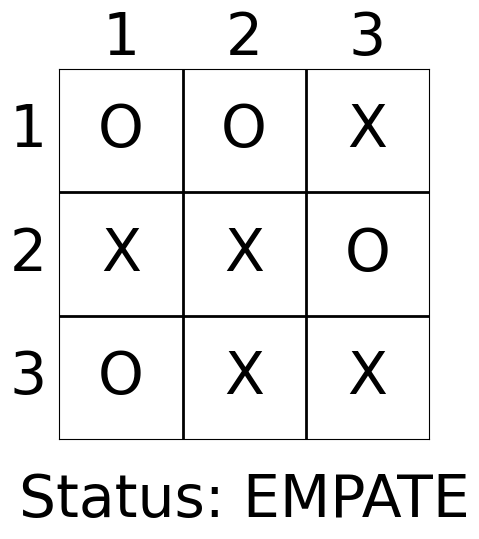

In [25]:
from IPython.display import clear_output

# Convertendo a lista de jogadas em um array 3x3
jogada = [0,0,0,0,0,0,0,0,0]
jogou = random.randint(1, 4)
plot_board(jogada)

finalizar_jogo = False

dificuldade = set_dificuldade()

while not finalizar_jogo:
    clear_output(wait=True)
    # Coletando a jogada
    linha,coluna = coleta_jogada()
    
    # Chamando a função de validação de jogada
    if valida_jogada(jogada,linha,coluna):
        # Realizando o ajuste da jogada a partir das posições de inserção informadas
        jogada = ajuste_jogada(jogada,linha,coluna)
        print('Jogada realizada!')
    else:
        print("Posição já ocupada!")
        continue # Recomeça solicitando a jogada para o usuário
    
    # Redefinindo o shape do array 2d para usar no classificador
    jogada = np.array(jogada).reshape(9,)

    # Obtenção do status do jogo após jogada do usuário
    status  = status_jogo(jogada)
    
    # Caso haja um vencedor o loop será encerrado
    if status_jogo(jogada) != "AINDA TEM JOGO":
        finalizar_jogo = True
        plot_board(jogada,status)
        break
    
    jogada = np.array(jogada).reshape(3,3)

    # Realização de jogada da máquina
    jogada, ifJogou = jogada_COM(jogada,dificuldade,jogou)
    jogou += 1

    # Redefinindo o shape do array para usar no classificador
    jogada = jogada.reshape(9,)

    # Obtenção do status do jogo após jogada da máquina
    status  = status_jogo(jogada)

    # Plotando o tabuleiro 
    plot_board(jogada,status,ifJogou)
    
    # Caso haja um vencedor o loop será encerrado
    if status_jogo(jogada) != "AINDA TEM JOGO":
        finalizar_jogo = True

### **Partida Rede x Minimax**

In [26]:
from IPython.display import clear_output

# Caminho para o arquivo
arquivo = "Populacao.txt"

if os.path.exists(arquivo) and os.path.getsize(arquivo) > 0:
    geracao = np.loadtxt(arquivo, dtype=float)
else:
    # Define a semente para reprodutibilidade
    np.random.seed(42)

    # Gerando cromossomos com a distribuição uniforme
    geracao = np.random.uniform(-1, 1, (50, 180))

    # Adicionando ruído aleatório aos cromossomos
    ruido = np.random.uniform(-0.1, 0.1, (50, 180))  # Ruído pequeno para aumentar a diversidade
    geracao += ruido

    # Criando uma nova coluna de zeros
    nova_coluna = np.zeros((geracao.shape[0], 1))

    # Concatenando verticalmente a coluna da geracao com a coluna de zeros
    geracao = np.hstack((geracao, nova_coluna))

rede = Rede(array_pesos=geracao)
    
# dificuldade = 1

while rede.get_geracao() < rede.get_total_geracao():
    dificuldade = 3
    partida = [0,0,0,0,0,0,0,0,0]
    jogou = random.randint(1,4)
    countRede = 0
    
    finalizar_jogo = False

    # clear_output(wait=True)

    while not finalizar_jogo:
        #Jogada da rede
        # print(partida)
        jogadaRede = rede.position(partida)
        countRede += 1
        linha = (jogadaRede -1) // 3 + 1
        coluna = (jogadaRede -1) % 3 + 1
        # print(f"Jogada da rede: {linha},{coluna}")
        if valida_jogada(partida, linha, coluna):
            partida = ajuste_jogada(partida, linha, coluna)
            #plot_board(partida,status_jogo(partida))
        else:
            # print("Jogada não realizada")
            # print(partida)
            if rede.get_geracao() < rede.get_total_geracao():
                rede.heuristica(partida,"Invalida", countRede)
            break

        if status_jogo(partida) != 'AINDA TEM JOGO':
            rede.heuristica(partida,"Invalida", countRede)
            finalizar_jogo = True
        
        
        partida = np.array(partida).reshape(3,3)
        partida, ifJogou = jogada_COM(partida,dificuldade,jogou)
        jogou += 1

        partida = np.array(partida).reshape(9,)

        status = status_jogo(partida)

        # plot_board(partida,status,ifJogou)

        if status_jogo(partida) != 'AINDA TEM JOGO':
            rede.heuristica(partida,"Invalida", countRede)
            finalizar_jogo = True
else:
    rede.salva_populacao()

Máx gerações: 5 Geração: 1 Aptidão Elitismo: 10.0
Máx gerações: 5 Geração: 2 Aptidão Elitismo: 10.0
Máx gerações: 5 Geração: 3 Aptidão Elitismo: 10.0
Máx gerações: 5 Geração: 4 Aptidão Elitismo: 10.0
Máx gerações: 5 Geração: 5 Aptidão Elitismo: 10.0


### **Partida Usuário x Rede**

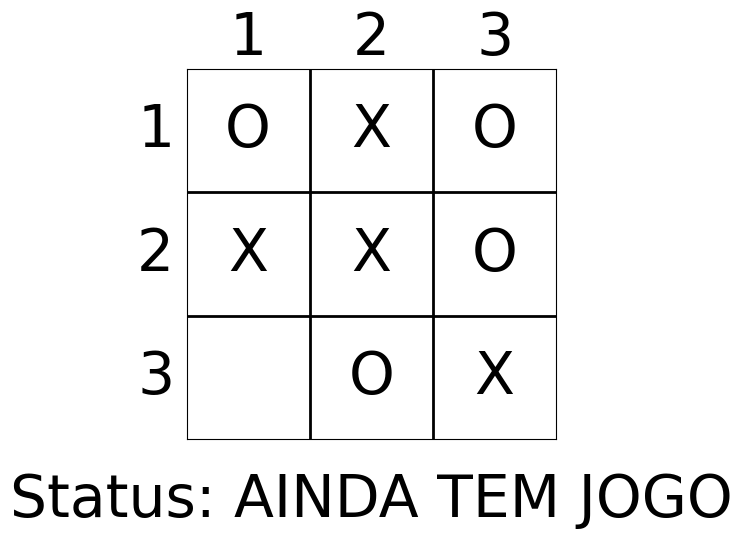

Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação já ocupada!
Posicação 

KeyboardInterrupt: 

In [27]:
from IPython.display import clear_output

arquivo = "Populacao.txt"

if os.path.exists(arquivo) and os.path.getsize(arquivo) > 0:
    geracao = np.loadtxt(arquivo, dtype=float)

rede = Rede(array_pesos=geracao)
# Convertendo a lista de jogadas em um array 3x3
partida = [0,0,0,0,0,0,0,0,0]
clear_output(wait=True)
plot_board(partida, status_jogo(partida))
finalizar_jogo = False

while not finalizar_jogo:
    jogadaRede = rede.position(partida)
    linha = (jogadaRede -1) // 3 + 1
    coluna = (jogadaRede -1) % 3 + 1
    # print(f"Jogada da rede: {linha},{coluna}")
    if valida_jogada(partida, linha, coluna):
        partida = ajuste_jogada(partida, linha, coluna)
        clear_output(wait=True)
        plot_board(partida,status_jogo(partida))
    else:
        print("Posicação já ocupada!")
        if rede.get_geracao() < rede.get_total_geracao():
            rede.heuristica(partida,"Invalida", countRede)
        continue

    if status_jogo(partida) != 'AINDA TEM JOGO':
        rede.heuristica(partida,"Invalida", countRede)
        finalizar_jogo = True

    linha,coluna = coleta_jogada()

    if valida_jogada(partida, linha, coluna):
        partida = ajuste_jogada(partida, linha, coluna, jogador=-1)
    else:
        print("Posicação já ocupada!")
        break

    clear_output(wait=True)
    plot_board(partida, status_jogo(partida))

    if status_jogo(partida) != 'AINDA TEM JOGO':
        finalizar_jogo = True

In [20]:
# from IPython.display import clear_output

# arquivo = "Populacao.txt"

# if os.path.exists(arquivo) and os.path.getsize(arquivo) > 0:
#     geracao = np.loadtxt(arquivo, dtype=float)

# rede = Rede(array_pesos=geracao)
# # Convertendo a lista de jogadas em um array 3x3
# partida = [0,0,0,0,0,0,0,0,0]
# clear_output(wait=True)
# plot_board(partida, status_jogo(partida))
# finalizar_jogo = False

# while not finalizar_jogo:
#     jogadaRede = rede.position(partida)
#     linha = (jogadaRede -1) // 3 + 1
#     coluna = (jogadaRede -1) % 3 + 1
#     # print(f"Jogada da rede: {linha},{coluna}")
#     if valida_jogada(partida, linha, coluna):
#         partida = ajuste_jogada(partida, linha, coluna)
#         clear_output(wait=True)
#         plot_board(partida,status_jogo(partida))
#     else:
#         # print("Jogada não realizada")
#         # print(partida)
#         if rede.get_geracao() < rede.get_total_geracao():
#             rede.heuristica(partida,"Invalida", countRede)
#         break

#     if status_jogo(partida) != 'AINDA TEM JOGO':
#         rede.heuristica(partida,"Invalida", countRede)
#         finalizar_jogo = True

#     linha,coluna = coleta_jogada()

#     if valida_jogada(partida, linha, coluna):
#         partida = ajuste_jogada(partida, linha, coluna, jogador=-1)
#     else:
#         print("Jogada não realizada")
#         break

#     clear_output(wait=True)
#     plot_board(partida, status_jogo(partida))

#     if status_jogo(partida) != 'AINDA TEM JOGO':
#         finalizar_jogo = True